In [1]:
from fastai.vision.all import *
import timm

In [2]:
Path.BASE_PATH = path = Path('mask')

In [3]:
trn_path = Path('sml')

In [4]:
cd /notebooks/

/notebooks


In [5]:
df = pd.read_csv(path/"train_labels.csv")

In [ ]:
resize_images(path/'images', dest=trn_path, max_size=256, recurse=True)

In [6]:
(path/'images').ls()

(#1817) [Path('images/vmjoagqsocvlzejinvgytizdxpbhzf.jpg'),Path('images/ljkyoarjjsfzpguocnnmteqqidnztx.jpg'),Path('images/tsdnumyxjxdtpmjzgsbuhaoibrbgur.jpg'),Path('images/radafdaijhzgynzcvgpdiaqpddfwrp.jpg'),Path('images/nrlywwygzrswfdbhjvdtakksrsvjgk.jpg'),Path('images/nncgaofbnlhkcvnvhajmgrxpomzzba.jpg'),Path('images/euaxozalqcqmhzyvxpiihzcvfzpcub.jpg'),Path('images/gzmchbgmbiwuyckveuenjgkutgaoqk.jpg'),Path('images/zbmmixvefcnotutstwrxzcxyjnqyul.jpg'),Path('images/wrgixgvogbvrvrvslnkuweluxuqlwq.jpg')...]

In [8]:
dls = ImageDataLoaders.from_csv(path, 'train_labels.csv', seed = 42, folder='sml', item_tfms=Resize((256)))

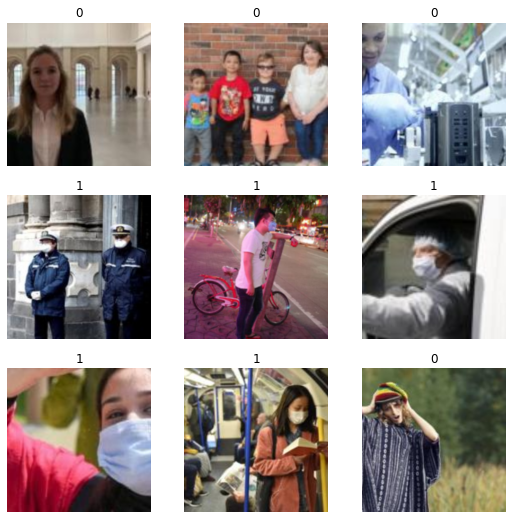

In [9]:
dls.show_batch()

In [10]:
def train(arch, item, batch, folder, epochs=5):
    dls = ImageDataLoaders.from_csv(path, 'train_labels.csv', seed = 42, folder=folder, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [13]:
learn = train('resnet26d', item=Resize(192), folder='sml',
              batch=aug_transforms(size=128, min_scale=0.75))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.766501,0.746356,0.130268,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.398227,0.503083,0.157088,00:08
1,0.367214,0.437033,0.130268,00:08
2,0.296963,0.318316,0.130268,00:08
3,0.238199,0.329941,0.126437,00:08
4,0.210266,0.299550,0.126437,00:08


In [14]:
arch = 'convnext_small_in22k'

In [15]:
learn = train(arch, item=Resize(192, method='squish'),folder='sml',
              batch=aug_transforms(size=128, min_scale=0.75))

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.467684,0.580337,0.061303,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.180139,0.308919,0.045977,00:39
1,0.143353,0.319674,0.045977,00:40
2,0.109236,0.286891,0.045977,00:40
3,0.075962,0.256513,0.038314,00:40
4,0.057536,0.247238,0.038314,00:40


In [16]:
learn = train(arch, item=Resize(192), folder='sml',
              batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,0.399466,0.307611,0.053640,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.132243,0.238736,0.053640,00:39
1,0.134914,0.182111,0.045977,00:40
2,0.103745,0.220529,0.034483,00:40
3,0.087728,0.220188,0.045977,00:40
4,0.076015,0.193486,0.034483,00:40


## padding

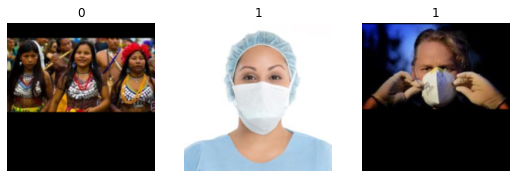

In [17]:
dls = ImageDataLoaders.from_csv(path, 'train_labels.csv', seed = 42, folder='sml',
    item_tfms=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))
dls.show_batch(max_n=3)

In [18]:
learn = train(arch, folder='sml',item=Resize((256), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=(171), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,0.402293,0.354517,0.045977,00:39


epoch,train_loss,valid_loss,error_rate,time
0,0.119657,0.413840,0.045977,01:08
1,0.134378,0.255006,0.042146,01:08
2,0.107286,0.158137,0.030651,01:08
3,0.076058,0.156077,0.030651,01:08
4,0.056609,0.153681,0.034483,01:08


## Test time augumentation

In [ ]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [ ]:
error_rate(preds, targs)

In [ ]:
learn.dls.train.show_batch(max_n=6, unique=True)

In [ ]:
tta_preds,_ = learn.tta(dl=valid)

In [ ]:
error_rate(tta_preds, targs)

## Scaling up to normal bigger images

In [ ]:
learn = train(arch, epochs=11,
              item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(256,192), min_scale=0.75))

In [ ]:
learn = train(arch, epochs=11, item=Resize(480, method='squish'),
              batch=aug_transforms(size=256, min_scale=0.75))

In [ ]:
tta_preds,targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

In [ ]:
files = get_image_files(path/'images')
files

In [ ]:
train_list = df.image.to_list()
train_list[:4]

In [ ]:
splitter = FuncSplitter(lambda o: Path(o).name not in train_list)
new_files = splitter(files)
train, test = new_files

In [ ]:
train_path, test_path = files[train], files[test]

In [ ]:
ss = pd.read_csv(path/'SampleSubmission.csv')
ss

In [ ]:
tst_files = test_path.sorted()
tst_dl = dls.test_dl(tst_files)

In [ ]:
preds,_ = learn.tta(dl=tst_dl)

In [ ]:
preds

In [ ]:
x = torch.max(preds, 1)

In [ ]:
x[0][:4]

In [ ]:
y = torch.argmax(preds, dim=1)

In [ ]:
y[:4]

In [ ]:
res = torch.where(y==0, 1-x[0], x[0])

In [ ]:
results = pd.Series(res.numpy(), name="target").round(2)
results

In [ ]:
ss['target'] = results
ss.to_csv('subm2.csv', index=False)
!head subm2.csv